In [1]:
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy import meshgrid
from mpl_toolkits.basemap import Basemap

import geopandas as gpd
from shapely.geometry  import Point
from shapely.geometry import shape
import seaborn as sns
import pandas as pd 
import indices as ii

# Figure 3

In [3]:
gcm_names=['MIROC_ESM','CanESM2','HadGEM_AO','GFDL_CM3']
i = 1
gcm_name=gcm_names[i]
map_bounds=[65, 40, 100, 5]

print('preparing plots for ' + gcm_name)

preparing plots for CanESM2


## Import data

In [4]:
path_out_IMD = '/home/vikram/BCSD_data/India_P_CH/'

In [5]:
out_id='gcm_'+gcm_name+'_imd'

bcsd_gcm_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/BCSD_outputs_'+out_id+'.npy'))
bcsd_gcm_test.shape

(19710, 33, 35)

In [6]:

imd_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_obs_imd_pred.npy'))
imd_train=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_obs_imd_train.npy'))
train_length =imd_train.shape[0]
gcm_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_gcm_'+gcm_name+'_imd_pred.npy'))
gcm_train=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_gcm_'+gcm_name+'_imd_train.npy'))



gcm_meta_01=np.load(path_out_IMD + '/bcsd_imd_metadata_'+gcm_name+'.npy',allow_pickle=True)
out_id='gcm_'+gcm_name+'_imd'
bcsd_gcm_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/BCSD_outputs_'+out_id+'.npy'))

st=gcm_meta_01.item()['st']
en=gcm_meta_01.item()['en']

lat_obs=gcm_meta_01.item()['lat_obs']
lat_gcm_01=gcm_meta_01.item()['lat_gcm']
lon_obs=gcm_meta_01.item()['lon_obs']
lon_gcm_01=gcm_meta_01.item()['lon_gcm']
mask=gcm_meta_01.item()['mask']

N1=imd_test.shape[1]
N2=imd_test.shape[2]


# j=0
# out_id='exp_0_run_'+str(j)+'_imd' 
# import copy

# bcsd_rnd_test=copy.deepcopy(bcsd_gcm_test)#uu.correct_nan_inf_neg(np.load(path_out_IMD + '/aBCSD_outputs_'+out_id+'.npy'))



data_gf_train=np.zeros(imd_train.shape)
data_gf_test=np.zeros(imd_test.shape)

for i in range(gcm_train.shape[0]):
  data_gf_train[i,:,:]=uu.regrid(gcm_train[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs,lon_obs)
  data_gf_test[i,:,:]=uu.regrid(gcm_test[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs,lon_obs)
  

In [7]:
bcsd_gcm_train = bcsd_gcm_test[:train_length]
bcsd_gcm_test = bcsd_gcm_test[train_length:]
bcsd_rnd_train = bcsd_gcm_train
bcsd_rnd_test = bcsd_gcm_test

## Checking imported data

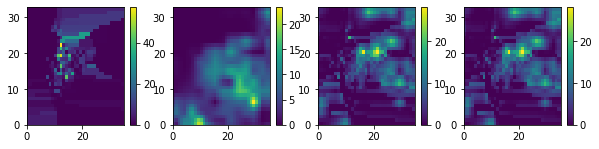

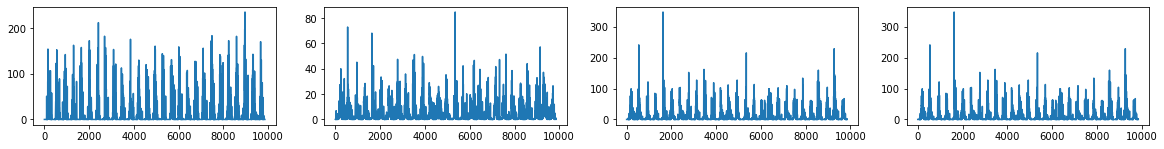

In [8]:
data_test=[imd_test,
      data_gf_test,
      bcsd_gcm_test,
      bcsd_rnd_test
      ]

data_train=[imd_train,
      data_gf_train,
      bcsd_gcm_train,
      bcsd_rnd_train
      ]
data =data_train

plt.figure(figsize=(10,10))
for i in range(4):
  plt.subplot(4,4,i+1)
  plt.pcolor(data[i][250,:,:])
  plt.colorbar()

plt.figure(figsize=(20,10))
for i in range(4):
  plt.subplot(4,4,i+1)
  plt.plot(data[i][:,7,7])



## Compute indices

In [23]:
Ntrain_years = 27
Ntest_years = 27 

from tqdm import tqdm
def spatial_ind_ly(func,data_all):
  D=len(data_all)
  calc_index=np.zeros((D,N1,N2))
  for d in tqdm(range(D)):
    for i in range(N1):
      for j in range(N2):
        calc_index[d,i,j]=np.mean(func(data_all[d][:,i,j],st,st + Ntest_years -1 ))
  return calc_index


In [28]:
### R50mm

R50mmindic_train=spatial_ind_ly(ii.R50mm_annualy_ly,data_train)
R50mmindic_test=spatial_ind_ly(ii.R50mm_annualy_ly,data_test)

### Rx1day
Rx1dayindic_train=spatial_ind_ly(ii.Rx1day_annualy_ly,data_train)
Rx1dayindic_test=spatial_ind_ly(ii.Rx1day_annualy_ly,data_test)

### CDD
CDDindic_train=spatial_ind_ly(ii.CDD_annualy_ly,data_train)
CDDindic_test=spatial_ind_ly(ii.CDD_annualy_ly,data_test)

### R99pTOT
R99pTOTindic_train=spatial_ind_ly(ii.R99pTOT_annualy_ly,data_train)
R99pTOTindic_test=spatial_ind_ly(ii.R99pTOT_annualy_ly,data_test)

100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.96s/it]


## Figure 3

In [29]:
def map_plot_cyl_final(data_lat_x_lon,lat_cen,lon_cen,map_bounds,clab,cmap,y_limit,ax,mp_spacing=10,subplot_iter=1,loff=1,coff=1,ex='both'):

  lat_box=uu.cen_to_box(lat_cen)
  lon_box=uu.cen_to_box(lon_cen)

  map = Basemap(projection='cyl',resolution='l',
                llcrnrlon=map_bounds[0], 
                urcrnrlat=map_bounds[1],
                urcrnrlon=map_bounds[2], 
                llcrnrlat=map_bounds[3])


  xx, yy = meshgrid(lon_box,lat_box )
  #return  dimenion of lat * lon
  map.pcolor(xx, yy, data_lat_x_lon,cmap=cmap)
  map.drawmeridians(np.arange(-180,180,mp_spacing),labels=[0,0,0,1], linewidth=1.0) #longitudes
  if loff==0:
    map.drawparallels(np.arange(-90,90,mp_spacing),labels=[1,0,0,0], linewidth=1.0) #latitudes
  else:
    map.drawparallels(np.arange(-90,90,mp_spacing),labels=[0,0,0,0], linewidth=1.0) #latitudes
  cbar = map.colorbar(extend=ex)
  #cbar.ax.set_yticklabels(['0','1','2','>3'])
  cbar.set_label(clab, rotation=90)
  plt.clim(y_limit)

  if coff==1:
    cbar.remove()

  #map.drawcountries(linewidth=1)
  map.readshapefile('/home/vikram/BCSD_Shapefiles/ind', 'IND', linewidth=1.0)

  map.drawcoastlines(linewidth=1)
  lxx=0.02
  lyy=0.98
  lcol='k'
  lsize=24
  lfamily='Tahoma'
  lweight=800
 # y_limit=[0,30]
  #clab='days'
  
  plt.text(lxx, lyy, chr(subplot_iter+96), horizontalalignment='left',verticalalignment='top', transform=ax.transAxes,fontweight=lweight,
           fontfamily=lfamily,fontsize=lsize,color=lcol)

Text(0.08, 0.35, 'R99pTOT')

findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


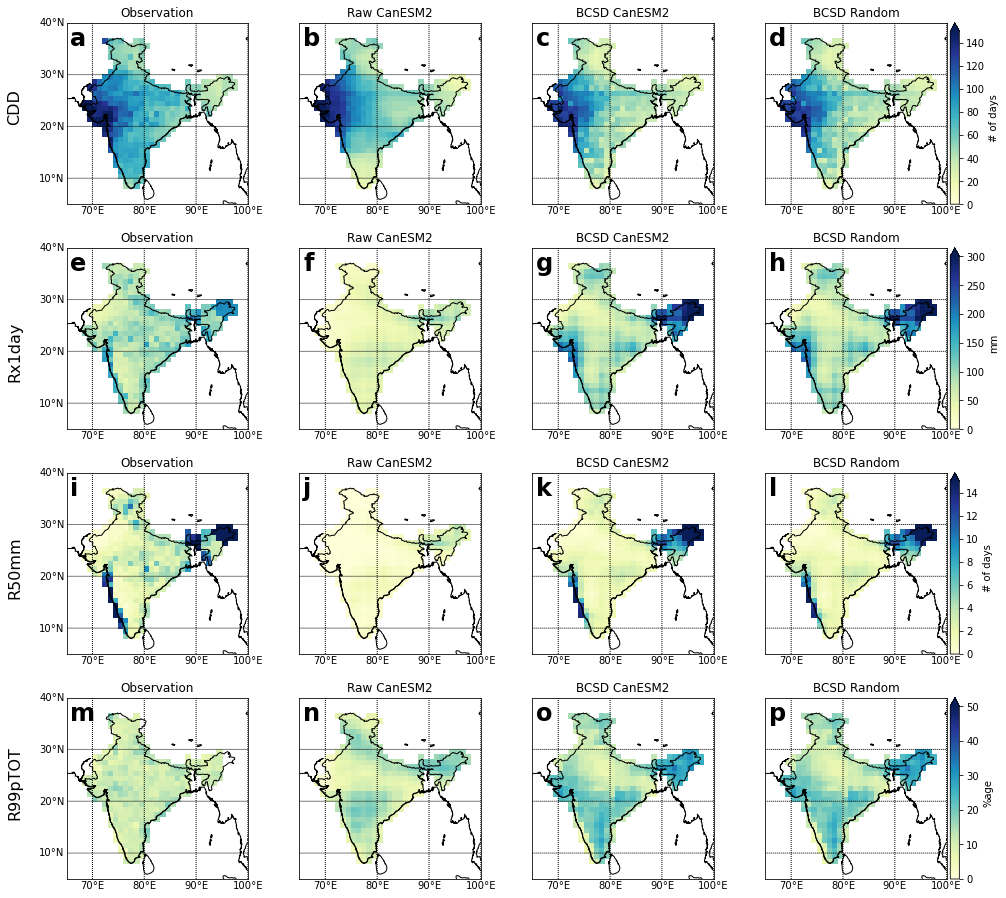

In [30]:
dapa=[
  CDDindic_train[0,:,:],
  CDDindic_train[1,:,:],
  CDDindic_train[2,:,:],
  CDDindic_train[3,:,:],
  Rx1dayindic_train[0,:,:],
  Rx1dayindic_train[1,:,:],
  Rx1dayindic_train[2,:,:],
  Rx1dayindic_train[3,:,:],
  R50mmindic_train[0,:,:],
  R50mmindic_train[1,:,:],
  R50mmindic_train[2,:,:],
  R50mmindic_train[3,:,:],
  R99pTOTindic_train[0,:,:],
  R99pTOTindic_train[1,:,:],
  R99pTOTindic_train[2,:,:],
  R99pTOTindic_train[3,:,:],
 ]

y_limits=[[0,150],
          [0,300],
          [0,15],
          [0,50],
          [0,100]]

labels=['# of days','mm','# of days','%age','# of days']
lofff=[0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1]
cofff=[1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0]

titlesx=['Observation','Raw '+gcm_name,'BCSD '+gcm_name,'BCSD Random']
titlesy=['CDD','Rx1day','R50mm','R99pTOT','HI32']
cmaps=['YlOrRd','YlOrRd','YlOrRd','YlOrRd','YlOrRd']
cmaps=['YlGnBu','YlGnBu','YlGnBu','YlGnBu','YlGnBu']
# cmaps=['jet','jet','YlOrRd','jet','YlOrRd']
#cmaps=['autumn','spring','summer','winter','jet']

ex='max'

fig=plt.figure(figsize=(16,20))
for rr in range(4):
  for cc in range(4):
    iter=rr*4+cc
    ax=plt.subplot(5,4,iter+1)
    
    if rr<=3:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask),lat_obs,lon_obs,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    else:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask2),lat_obs_ncar,lon_obs_ncar,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    
    plt.title(titlesx[cc])


fig.text(0.08, 0.82, titlesy[0], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.65, titlesy[1], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.5, titlesy[2], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.35, titlesy[3], va='center', ha='center', rotation='vertical', fontsize=16)
# fig.text(0.08, 0.2, titlesy[4], va='center', ha='center', rotation='vertical', fontsize=16)

# plt.savefig('./Figures/Figure3/extended_'+gcm_name+'.svg')


Text(0.08, 0.35, 'R99pTOT')

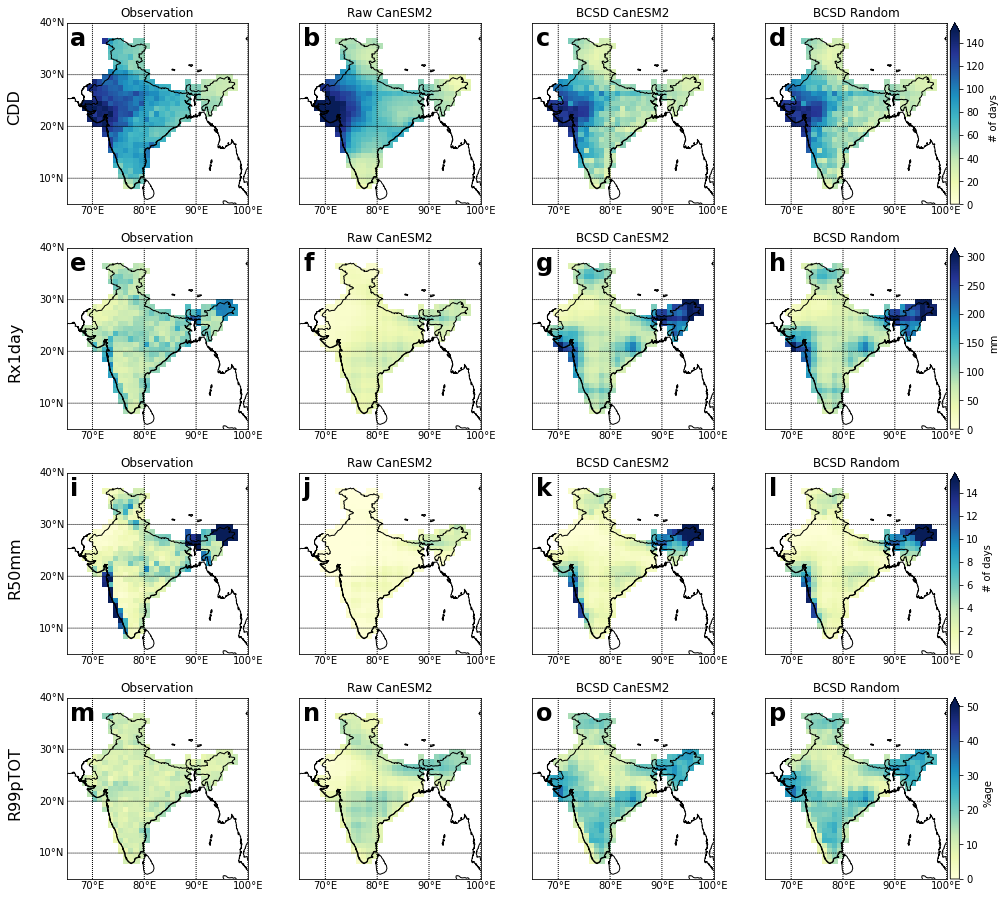

In [31]:
dapa=[
  CDDindic_test[0,:,:],
  CDDindic_test[1,:,:],
  CDDindic_test[2,:,:],
  CDDindic_test[3,:,:],
  Rx1dayindic_test[0,:,:],
  Rx1dayindic_test[1,:,:],
  Rx1dayindic_test[2,:,:],
  Rx1dayindic_test[3,:,:],
  R50mmindic_test[0,:,:],
  R50mmindic_test[1,:,:],
  R50mmindic_test[2,:,:],
  R50mmindic_test[3,:,:],
  R99pTOTindic_test[0,:,:],
  R99pTOTindic_test[1,:,:],
  R99pTOTindic_test[2,:,:],
  R99pTOTindic_test[3,:,:],
 ]

y_limits=[[0,150],
          [0,300],
          [0,15],
          [0,50],
          [0,100]]

labels=['# of days','mm','# of days','%age','# of days']
lofff=[0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1]
cofff=[1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0]

titlesx=['Observation','Raw '+gcm_name,'BCSD '+gcm_name,'BCSD Random']
titlesy=['CDD','Rx1day','R50mm','R99pTOT','HI32']
cmaps=['YlOrRd','YlOrRd','YlOrRd','YlOrRd','YlOrRd']
cmaps=['YlGnBu','YlGnBu','YlGnBu','YlGnBu','YlGnBu']
# cmaps=['jet','jet','YlOrRd','jet','YlOrRd']
#cmaps=['autumn','spring','summer','winter','jet']

ex='max'

fig=plt.figure(figsize=(16,20))
for rr in range(4):
  for cc in range(4):
    iter=rr*4+cc
    ax=plt.subplot(5,4,iter+1)
    
    if rr<=3:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask),lat_obs,lon_obs,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    else:
      map_plot_cyl_final(ma.masked_array(dapa[iter], mask=mask2),lat_obs_ncar,lon_obs_ncar,map_bounds,labels[rr],cmaps[rr],y_limits[rr],ax,mp_spacing=10,subplot_iter=iter+1,loff=lofff[iter],coff=cofff[iter],ex=ex)
    
    plt.title(titlesx[cc])


fig.text(0.08, 0.82, titlesy[0], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.65, titlesy[1], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.5, titlesy[2], va='center', ha='center', rotation='vertical', fontsize=16)
fig.text(0.08, 0.35, titlesy[3], va='center', ha='center', rotation='vertical', fontsize=16)
# fig.text(0.08, 0.2, titlesy[4], va='center', ha='center', rotation='vertical', fontsize=16)

# plt.savefig('./Figures/Figure3/extended_'+gcm_name+'.svg')


# S scores

In [32]:
def S_score_2D(data_ref, data_model,mask_inf):
    # mask is true for exterior values
    data_1 = data_ref
    data_2 = data_model 
    ind_1 = np.isnan(data_1)
    ind_2 = np.isnan(data_2)
    data_1[ind_2] = np.nan
    data_2[ind_1] = np.nan
    data_1[mask_inf == True] = np.nan
    data_2[mask_inf == True] = np.nan

    data_1 = data_1.flatten()
    data_2 = data_2.flatten()
    
    data_1 =  np.delete(data_1,np.isnan(data_1))
    data_2 =  np.delete(data_2,np.isnan(data_2))
    R = np.corrcoef(data_1,data_2)[0,1]

    SDR = np.std(data_2)/np.std(data_1)

    S_score = (1+R)**4  / ( 4 * (SDR + 1 / SDR)**2 )
    
    
    return S_score

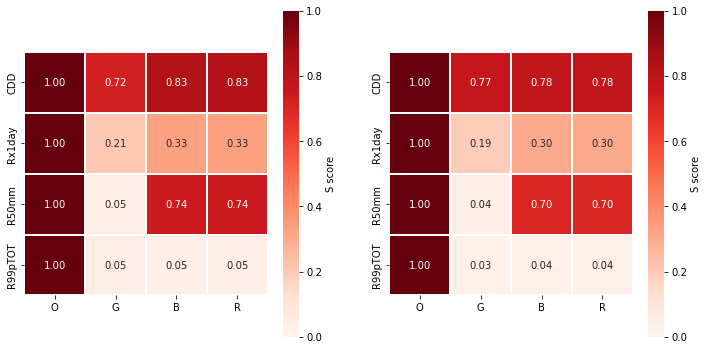

In [39]:
D=4
N_index= 4
S_score_matrix = np.zeros((N_index,D))
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
for itr,index in enumerate([CDDindic_train,Rx1dayindic_train,R50mmindic_train,R99pTOTindic_train]):
    for d in range(D):
        S_score_matrix[itr,d] = (S_score_2D(index[0,:,:],index[d,:,:],mask))
        
        
        
h=sns.heatmap(S_score_matrix , linewidth = 2 , cmap = 'Reds', 
          annot=True,
          fmt=".2f", square=True,
          xticklabels=['O','G','B','R'],
          yticklabels=['CDD','Rx1day','R50mm','R99pTOT'],vmin=0,vmax=1,
             
          cbar_kws={'label': 'S score','extend':None},cbar = True)

# cbar_kws={'label': '°C','extend':'max'},cbar

plt.subplot(1,2,2)
S_score_matrix = np.zeros((N_index,D))
for itr,index in enumerate([CDDindic_test,Rx1dayindic_test,R50mmindic_test,R99pTOTindic_test]):
    for d in range(D):
        S_score_matrix[itr,d] = (S_score_2D(index[0,:,:],index[d,:,:],mask))
        
        
        
h=sns.heatmap(S_score_matrix , linewidth = 2 , cmap = 'Reds', 
          annot=True,
          fmt=".2f", square=True,
          xticklabels=['O','G','B','R'],
          yticklabels=['CDD','Rx1day','R50mm','R99pTOT'],vmin=0,vmax=1,
             
          cbar_kws={'label': 'S score','extend':None},cbar = True)

## Plotting 

titles123=['Obs',
            gcm_name,
        'BCSD-'+gcm_name,
        'BCSD-Rnd_0']


lofff=[0,0,1,1,1,0,1,1,1,0,1,1,1]


def plot_indices(R20_all,titles,title1,clab,y_limit,cmap,ex='both'):

  fig=plt.figure(figsize=(24,24))
  D=4

  for d in range(D):
    ax=plt.subplot(1,4,d+1)

    map_plot_cyl(ma.masked_array(R20_all[d,:,:], mask=mask),lat_obs,lon_obs,map_bounds,clab,cmap,y_limit,ax,mp_spacing=10,subplot_iter=d+1,loff=lofff[d],ex=ex)
    plt.title(titles[d])
    if d == 3:
      plt.text(0.5, 1.15, title1, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,
               fontweight=600,fontsize=20,color='k')
          
  # plt.savefig('./Figures/Figure3/indices/imd_indices_'+title1+'.png')


# br99=get_rmse_spatially(R99pTOTindic,lat_obs,lon_obs)
# plot_heatmap(br99,[0,15],titles,".0f",'Reds','R99pTOT')

# ar50=get_rmse_spatially(R50mmindic,lat_obs,lon_obs)
# plot_heatmap(ar50,[0,10],titles,".0f",'Reds','R50mm')

# arx=get_rmse_spatially(Rx1dayindic,lat_obs,lon_obs)
# plot_heatmap(arx,[0,100],titles,".0f",'Reds','Rx1day')

# acdd=get_rmse_spatially(CDDindic,lat_obs,lon_obs)
# plot_heatmap(acdd,[0,100],titles,".0f",'Reds','CDD')

### HI32


# hit_indic=np.load('/content/drive/MyDrive/BiasCorr/output_rh_tas_daily/heat_index.npy')
# plot_indices(Rx1dayindic,titles123,'Rx1day','mm',[0,150],'Reds',ex='max')
# plot_indices(CDDindic,titles123,'CDD','# of days',[0,200],'jet',ex='max')
# plot_indices(R99pTOTindic,titles,'R99pTOT','%age',[0,30],'jet',ex='max')


# mask2=np.load('/content/drive/MyDrive/BiasCorr/output_rh_tas_daily/mask_shape.npy')
# lat_obs_ncar=np.load('/content/drive/MyDrive/BiasCorr/output_rh_tas_daily/lat_obs_ncar.npy')
# lon_obs_ncar=np.load('/content/drive/MyDrive/BiasCorr/output_rh_tas_daily/lon_obs_ncar.npy')

## RMSE final

ind1h=get_rmse_spatially(dapa[:4],lat_obs,lon_obs)
ind2h=get_rmse_spatially(dapa[4:8],lat_obs,lon_obs)
ind3h=get_rmse_spatially(dapa[8:12],lat_obs,lon_obs)
ind4h=get_rmse_spatially(dapa[12:16],lat_obs,lon_obs)
# ind5h=get_rmse_spatially(dapa[16:20],lat_obs_ncar,lon_obs_ncar)

titles=['Obs','GCM','BC-G','BC-R']

labels=['# of days','mm','# of days','%age','# of days']

def plot_hmap(data_corr,ylim,titles,fmt,cmap):
  fig=plt.figure(figsize=(25,15))
  S=data_corr[0].shape[0]
  for iii in range(4):
    for subs in range(S):
      ax=plt.subplot(5,6,iii*6+subs+1)
      if subs < S-1:
        cbarI=False
      else:
        cbarI=True     
      data_set = data_corr[iii][subs,:,:]
      h=sns.heatmap(data_set , linewidth = 2 , cmap = cmap, 
                  annot=True,
                  fmt=fmt ,square=True,
                  xticklabels=titles,
                  yticklabels=titles,vmin=ylim[iii][0],vmax=ylim[iii][1],
                  cbar_kws={'label': labels[iii],'extend':'max'}, cbar=cbarI)
      if iii==0:
        plt.title(region_shapes['State_Name'][subs])
        
      lxx=-0.2
      lyy=1
      lcol='k'
      lsize=24
      lfamily='Tahoma'
      lweight=800
      
      plt.text(lxx, lyy,  chr(iii*4+subs+1+96), horizontalalignment='right',verticalalignment='top', transform=ax.transAxes,fontweight=lweight,
              fontsize=lsize,color=lcol)    
  titlesy=['CDD','Rx1day','R50mm','R99pTOT','HI32']
      
  fig.text(0.11, 0.82, titlesy[0], va='center', ha='center', rotation='vertical', fontsize=16)
  fig.text(0.11, 0.65, titlesy[1], va='center', ha='center', rotation='vertical', fontsize=16)
  fig.text(0.11, 0.5, titlesy[2], va='center', ha='center', rotation='vertical', fontsize=16)
  fig.text(0.11, 0.35, titlesy[3], va='center', ha='center', rotation='vertical', fontsize=16)
  # fig.text(0.11, 0.2, titlesy[4], va='center', ha='center', rotation='vertical', fontsize=16)

  fig.suptitle(gcm_name)
  # plt.savefig('/content/drive/MyDrive/Figures/Figure3/extended_rmse_'+gcm_name+'.svg')

  plt.show()

plot_hmap([ind1h,ind2h,ind3h,ind4h,ind4h],[[0,100],[0,100],[0,10],[0,15],[0,100]],titles,".1f",'Reds')

## RMSE finalss

In [41]:
titlesy=['GCM','BC-G','BC-R']
titlesx=['NW','C','NC','NE','NM','P']
labels=['# of days','mm','# of days','%age','# of days']
titles=[titlesx,titlesy]
def plot_hmap_short(data_corr,ylim,titles,fmt,cmap):
  titlesy=['CDD','Rx1day','R50mm','R99pTOT','HI32']
  fig=plt.figure(figsize=(12,9))
  S=data_corr[0].shape[0]
  for iii in range(4):
      ax=plt.subplot(3,2,iii+1)
      data_set=np.zeros((6,3))
      for subs in range(S):
        data_set[subs,:]= data_corr[iii][subs,1:,0]

      h=sns.heatmap(data_set.T , linewidth = 2 , cmap = cmap, 
                  annot=True,
                  fmt=fmt ,square=True,
                  xticklabels=titles[0],
                  yticklabels=titles[1],vmin=ylim[iii][0],vmax=ylim[iii][1],
                  cbar_kws={'label': labels[iii],'extend':'max'})
        
      lxx=0
      lyy=1
      lcol='k'
      lsize=24
      lfamily='Tahoma'
      lweight=800
      
      plt.text(lxx, lyy,  chr(iii+1+96), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=lweight,
              fontsize=lsize,color=lcol)    
  
      plt.title(titlesy[iii])

  fig.suptitle(gcm_name)
  # plt.savefig('/content/drive/MyDrive/Figures/Figure3/extended_rmse_ss'+gcm_name+'.svg')

  plt.show()

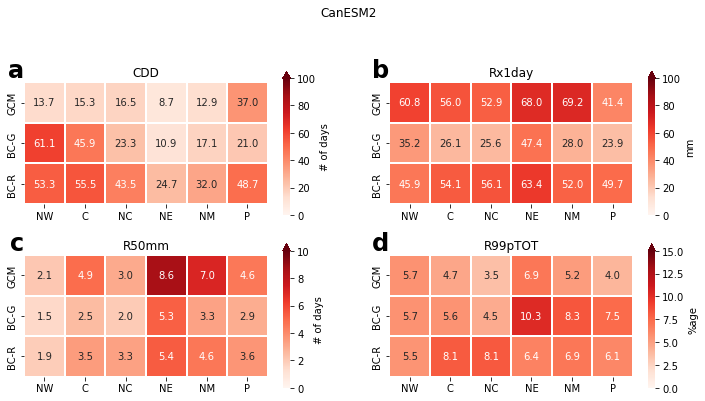

In [43]:
plot_hmap_short([ind1h,ind2h,ind3h,ind4h,ind4h],[[0,100],[0,100],[0,10],[0,15],[0,100]],titles,".1f",'Reds')